In [1]:
# Basic math/stats
import os
import math
import numpy as np
import pandas as pd
from scipy import stats

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import gpytorch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
# Create PyTorch Dataset
class HousingDataset(Dataset):
  def __init__(self, features, targets):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.targets = torch.tensor(targets, dtype=torch.float32)
    self.n_samples = features.shape[0]

  def __getitem__(self, index):
    return self.features[index], self.targets[index]

  def __len__(self):
    return self.n_samples

# Define KISS-GP Model
class GPRegressionModel(gpytorch.models.ExactGP, nn.Module):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPRegressionModel_MixedKernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_MixedKernel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
'''
# Define KISS-GP Model
class GPRegressionModel(gpytorch.models.ExactGP, nn.Module):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
'''
# Define training function
def train():
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        training_loss_vec.append(loss.item())

        print(f'Iteration {i}, Loss: {loss.item()}')

In [3]:
# Get the dataset csv file
df_raw = pd.read_csv('dataset.csv')

# Drop 'id'
df_clean = df_raw.drop(['id'], axis=1)

# Replace 'yr_renovated' with 'renovated' Boolean
df_clean['renovated'] = (df_clean["yr_renovated"] != 0).astype(int)
df_clean = df_clean.drop(['yr_renovated'], axis=1)

# Replace complex 'date' with 'yr_sold' (year of sale)
df_clean['yr_sold'] = [int(df_clean['date'][i][:4]) for i in range(len(df_clean))]
df_clean = df_clean.drop(['date'], axis=1)

# Split into training/testing sets
df_train_unscaled, df_test_unscaled = train_test_split(df_clean, test_size=0.6, random_state=0)

# Scale datasets
scaler = StandardScaler()
scaled_train_values = scaler.fit_transform(df_train_unscaled)
scaled_test_values = scaler.transform(df_test_unscaled)

## HERE
price_scaler = StandardScaler()
price_scaler.fit(np.array(df_train_unscaled['price']).reshape([-1,1]))

sqft_living_scaler = StandardScaler()
sqft_living_scaler.fit(np.array(df_train_unscaled['sqft_living']).reshape([-1,1]))

df_train = pd.DataFrame(scaled_train_values, columns=df_clean.columns)
df_test = pd.DataFrame(scaled_test_values, columns=df_clean.columns)

#### EXPERIMENTAL ####
# Remove outliers from training set
df_train = df_train[(np.abs(stats.zscore(df_train)) < 3).all(axis=1)]
#### EXPERIMENTAL ####

# Set training features and targets
train_features = df_train[['sqft_living']].values
train_targets = df_train['price'].values

# Set testing features and targets (these should match above)
test_features = df_test[['sqft_living']].values
test_targets = df_test['price'].values

# Transform the dataset to PyTorch Class
train_dataset = HousingDataset(train_features, train_targets)
test_dataset = HousingDataset(test_features, test_targets)

# Transform training/testing sets to PyTorch tensors
train_x = train_dataset.features
train_y = train_dataset.targets
test_x = test_dataset.features
test_y = test_dataset.targets

# For future visualizations
##x_visual = torch.tensor(np.linspace(float(train_x.min()), float(train_x.max()), 1000).reshape([-1,1]))

x_visual = torch.tensor(np.linspace(float(min(train_x.min(), test_x.min())),
                         float(max(train_x.max(), test_x.max())),
                               1000).reshape([-1,1]))

In [4]:
# PERFORM BASIC LINEAR REGRESSION

LR_model = LinearRegression()
LR_model.fit(train_x, train_y)

train_LR_mean_scaled = LR_model.predict(train_x)
test_LR_mean_scaled = LR_model.predict(test_x)

train_LR_mean = price_scaler.inverse_transform(np.array(train_LR_mean_scaled).reshape([-1,1]))
test_LR_mean = price_scaler.inverse_transform(np.array(test_LR_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for LR
LR_visual_mean = LR_model.predict(x_visual)

In [5]:
# PERFORM KISS-GP (SKI) REGRESSION

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_SKI_mean_scaled = prediction.mean
    test_SKI_var_scaled = prediction.variance

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_SKI_mean_scaled = prediction.mean
    train_SKI_var_scaled = prediction.variance

# Unscale the predictions (back to $ values)
train_SKI_mean = price_scaler.inverse_transform(np.array(train_SKI_mean_scaled).reshape([-1,1]))
test_SKI_mean = price_scaler.inverse_transform(np.array(test_SKI_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for KISS-GP SKI
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    SKI_visual_mean = prediction.mean
    SKI_visual_var = prediction.variance

/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  res = cls(index_tensor, value_tensor, interp_size)


Iteration 0, Loss: 0.9120075106620789
Iteration 1, Loss: 0.9001993536949158
Iteration 2, Loss: 0.8885113596916199
Iteration 3, Loss: 0.8769642114639282
Iteration 4, Loss: 0.8655800223350525
Iteration 5, Loss: 0.8543816208839417
Iteration 6, Loss: 0.843393862247467


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 7, Loss: 0.8326430916786194


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 8, Loss: 0.8221575617790222


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 9, Loss: 0.811964750289917


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 10, Loss: 0.802095353603363


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 11, Loss: 0.7925808429718018


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 12, Loss: 0.7834521532058716


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 13, Loss: 0.7747403383255005


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 14, Loss: 0.7664762139320374


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 15, Loss: 0.7586907148361206
Iteration 16, Loss: 0.7514107823371887


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 17, Loss: 0.7446632981300354


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 18, Loss: 0.7384728789329529


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 19, Loss: 0.7328583598136902


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 20, Loss: 0.7278344631195068


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 21, Loss: 0.7234115600585938


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 22, Loss: 0.7195927500724792


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 23, Loss: 0.7163717150688171


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 24, Loss: 0.7137339115142822


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 25, Loss: 0.711658239364624


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 26, Loss: 0.7101094126701355


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 27, Loss: 0.7090436816215515


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 28, Loss: 0.7084100246429443


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 29, Loss: 0.7081483006477356


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 30, Loss: 0.7081882953643799


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 31, Loss: 0.7084643244743347


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 32, Loss: 0.7089031338691711


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 33, Loss: 0.7094379663467407


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 34, Loss: 0.7100046873092651


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 35, Loss: 0.7105494737625122


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 36, Loss: 0.7110273241996765


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 37, Loss: 0.7114040851593018


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 38, Loss: 0.7116624712944031


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 39, Loss: 0.7117899060249329


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 40, Loss: 0.7117917537689209


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 41, Loss: 0.7116714119911194


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 42, Loss: 0.7114518284797668


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 43, Loss: 0.7111524343490601


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 44, Loss: 0.7107957601547241


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 45, Loss: 0.7104067206382751


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 46, Loss: 0.7100065350532532


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 47, Loss: 0.7096155285835266


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 48, Loss: 0.7092499136924744


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 49, Loss: 0.7089208960533142
CPU times: user 1min 4s, sys: 458 ms, total: 1min 4s
Wall time: 16.2 s


/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [6]:
# PERFORM STANDARD GP WITH MIXED KERNEL

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel_MixedKernel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_EGP_mean_scaled = prediction.mean
    test_EGP_var_scaled = prediction.variance

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_EGP_mean_scaled = prediction.mean
    train_EGP_var_scaled = prediction.variance

# Unscale the predictions (back to $ values)
train_EGP_mean = price_scaler.inverse_transform(np.array(train_EGP_mean_scaled).reshape([-1,1]))
test_EGP_mean = price_scaler.inverse_transform(np.array(test_EGP_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for ExactGP (Mixed Kernel)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    EGP_visual_mean = prediction.mean
    EGP_visual_var = prediction.variance

Iteration 0, Loss: 0.9119400382041931
Iteration 1, Loss: 0.9001317620277405
Iteration 2, Loss: 0.8884397149085999
Iteration 3, Loss: 0.8768866658210754
Iteration 4, Loss: 0.8654953837394714
Iteration 5, Loss: 0.85428786277771
Iteration 6, Loss: 0.8432905077934265
Iteration 7, Loss: 0.8325291275978088
Iteration 8, Loss: 0.8220312595367432
Iteration 9, Loss: 0.8118263483047485
Iteration 10, Loss: 0.8019436001777649
Iteration 11, Loss: 0.7924138307571411
Iteration 12, Loss: 0.7832691073417664
Iteration 13, Loss: 0.7745389938354492
Iteration 14, Loss: 0.7662556767463684
Iteration 15, Loss: 0.7584481239318848
Iteration 16, Loss: 0.7511472105979919
Iteration 17, Loss: 0.7443780303001404
Iteration 18, Loss: 0.7381653189659119
Iteration 19, Loss: 0.7325291037559509
Iteration 20, Loss: 0.7274843454360962
Iteration 21, Loss: 0.7230417132377625
Iteration 22, Loss: 0.7192034721374512
Iteration 23, Loss: 0.7159646153450012
Iteration 24, Loss: 0.7133108377456665
Iteration 25, Loss: 0.711219131946563

/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [7]:
# PERFORM RESIDUAL GP REGRESSION

basis_model = LinearRegression()
basis_model.fit(train_x, train_y)

basis_y = basis_model.predict(train_x)

# True - Prediction
res_train_x = train_y - basis_y

train_LR_mean = price_scaler.inverse_transform(np.array(train_LR_mean_scaled).reshape([-1,1]))
test_LR_mean = price_scaler.inverse_transform(np.array(test_LR_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for LR
LR_visual_mean = LR_model.predict(x_visual)

In [8]:
basis_model = LinearRegression()
basis_model.fit(train_x, train_y)

basis_y_train = basis_model.predict(train_x)
basis_y_test = basis_model.predict(test_x)
basis_y_visual = basis_model.predict(x_visual)

# True - Prediction = Residuals
res_train_x = train_y - basis_y_train

# ======== Fit KISS-GP (SKI) on the residuals ======== #

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Define the likelihood and model here
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, res_train_x, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# To hold training losses
training_loss_vec = []

# Train the model
%time train()

# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Acquire predictions on the testing set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(test_x))
    test_ADD_mean_scaled = prediction.mean
    test_ADD_var_scaled = prediction.variance

test_ADD_mean_scaled = test_ADD_mean_scaled + basis_y_test

# Acquire predictions on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(train_x))
    train_ADD_mean_scaled = prediction.mean
    train_ADD_var_scaled = prediction.variance

train_ADD_mean_scaled = train_ADD_mean_scaled + basis_y_train

# Unscale the predictions (back to $ values)
train_ADD_mean = price_scaler.inverse_transform(np.array(train_ADD_mean_scaled).reshape([-1,1]))
test_ADD_mean = price_scaler.inverse_transform(np.array(test_ADD_mean_scaled).reshape([-1,1]))

# Acquire predictions on the "visual" set for KISS-GP SKI
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_visual.to(torch.float32)))
    ADD_visual_mean = prediction.mean
    ADD_visual_var = prediction.variance

ADD_visual_mean = ADD_visual_mean + basis_y_visual


Iteration 0, Loss: 0.912007749080658
Iteration 1, Loss: 0.9001993536949158
Iteration 2, Loss: 0.8885111212730408
Iteration 3, Loss: 0.8769636750221252
Iteration 4, Loss: 0.8655794858932495
Iteration 5, Loss: 0.8543810248374939
Iteration 6, Loss: 0.8433941006660461
Iteration 7, Loss: 0.8326436281204224


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 8, Loss: 0.8221573829650879


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 9, Loss: 0.8119643330574036


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 10, Loss: 0.8020954728126526


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 11, Loss: 0.7925810813903809


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 12, Loss: 0.7834519743919373
Iteration 13, Loss: 0.7747400999069214
Iteration 14, Loss: 0.7664763331413269


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 15, Loss: 0.758690357208252


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 16, Loss: 0.7514104843139648


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 17, Loss: 0.7446643710136414


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 18, Loss: 0.7384729385375977


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 19, Loss: 0.7328582406044006
Iteration 20, Loss: 0.7278345227241516


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 21, Loss: 0.7234117388725281
Iteration 22, Loss: 0.7195920348167419
Iteration 23, Loss: 0.716371476650238


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 24, Loss: 0.713735044002533


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 25, Loss: 0.7116584181785583


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 26, Loss: 0.7101088166236877


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 27, Loss: 0.7090432643890381


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 28, Loss: 0.7084095478057861


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 29, Loss: 0.708147406578064
Iteration 30, Loss: 0.708187997341156


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 31, Loss: 0.7084641456604004


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 32, Loss: 0.708903431892395


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 33, Loss: 0.709438681602478


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 34, Loss: 0.7100036144256592


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 35, Loss: 0.7105496525764465


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 36, Loss: 0.7110276818275452
Iteration 37, Loss: 0.7114043235778809


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 38, Loss: 0.7116627097129822


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 39, Loss: 0.7117902040481567


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 40, Loss: 0.711790919303894


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 41, Loss: 0.7116724252700806


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 42, Loss: 0.7114510536193848


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 43, Loss: 0.7111513018608093


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 44, Loss: 0.71079421043396


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 45, Loss: 0.7104051113128662


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 46, Loss: 0.7100055813789368


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 47, Loss: 0.7096149325370789


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 48, Loss: 0.7092494368553162


/home/dave/ml/my_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iteration 49, Loss: 0.7089216709136963
CPU times: user 1min 3s, sys: 636 ms, total: 1min 4s
Wall time: 16.1 s


/home/dave/ml/my_env/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


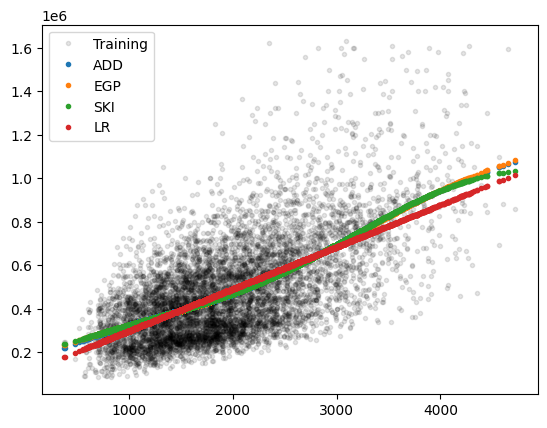

In [9]:
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), 'k.', alpha=0.1, label='Training')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x).reshape([-1,1])), train_ADD_mean, '.', label='ADD')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x).reshape([-1,1])), train_EGP_mean, '.', label='EGP')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x).reshape([-1,1])), train_SKI_mean, '.', label='SKI')
plt.plot(sqft_living_scaler.inverse_transform(np.array(train_x).reshape([-1,1])), train_LR_mean, '.', label='LR')
plt.legend()

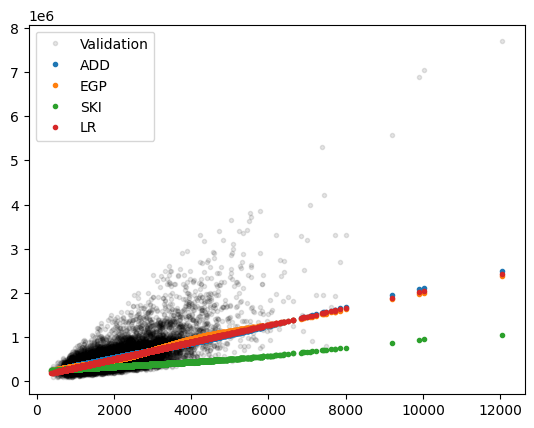

In [10]:
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), 'k.', alpha=0.1, label='Validation')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])), test_ADD_mean, '.', label='ADD')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])), test_EGP_mean, '.', label='EGP')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])), test_SKI_mean, '.', label='SKI')
plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])), test_LR_mean, '.', label='LR')
plt.legend()

In [11]:
print('Linear Regression MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_LR_mean))
print('KISS-GP (SKI) MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_SKI_mean))
print('ExactGP Mixture MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_EGP_mean))
print('Residual Model MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_ADD_mean))
print('\n')

print('Linear Regression MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_LR_mean))
print('KISS-GP (SKI) MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_SKI_mean))
print('ExactGP Mixture MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_EGP_mean))
print('Residual Model MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), test_ADD_mean))
print('\n')

print('Linear Regression Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_LR_mean)))
print('KISS-GP (SKI) Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_SKI_mean)))
print('ExactGP Mixture Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_EGP_mean)))
print('Residual Model Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])) - test_ADD_mean)))

Linear Regression MAE: 167566.45
KISS-GP (SKI) MAE: 237218.5
ExactGP Mixture MAE:  165650.4
Residual Model MAE:  171829.14


Linear Regression MSE: 76755080000.0
KISS-GP (SKI) MSE: 157868210000.0
ExactGP Mixture MSE:  74451380000.0
Residual Model MSE:  77894100000.0


Linear Regression Median Absolute Error: 120414.19
KISS-GP (SKI) Median Absolute Error: 139829.28
ExactGP Mixture Median Absolute Error: 120817.19
Residual Model Median Absolute Error: 129545.64


In [12]:
print('Linear Regression MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_LR_mean))
print('KISS-GP (SKI) MAE:', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_SKI_mean))
print('ExactGP Mixture MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_EGP_mean))
print('Residual Model MAE: ', mean_absolute_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_ADD_mean))
print('\n')

print('Linear Regression MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_LR_mean))
print('KISS-GP (SKI) MSE:', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_SKI_mean))
print('ExactGP Mixture MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_EGP_mean))
print('Residual Model MSE: ', mean_squared_error(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])), train_ADD_mean))
print('\n')

print('Linear Regression Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_LR_mean)))
print('KISS-GP (SKI) Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_SKI_mean)))
print('ExactGP Mixture Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_EGP_mean)))
print('Residual Model Median Absolute Error:', np.median(np.abs(price_scaler.inverse_transform(np.array(train_y).reshape([-1,1])) - train_ADD_mean)))

Linear Regression MAE: 138640.77
KISS-GP (SKI) MAE: 137272.5
ExactGP Mixture MAE:  137283.31
Residual Model MAE:  137262.81


Linear Regression MSE: 32389420000.0
KISS-GP (SKI) MSE: 31913978000.0
ExactGP Mixture MSE:  31912737000.0
Residual Model MSE:  31907635000.0


Linear Regression Median Absolute Error: 117797.84
KISS-GP (SKI) Median Absolute Error: 117593.47
ExactGP Mixture Median Absolute Error: 117569.0
Residual Model Median Absolute Error: 117838.22


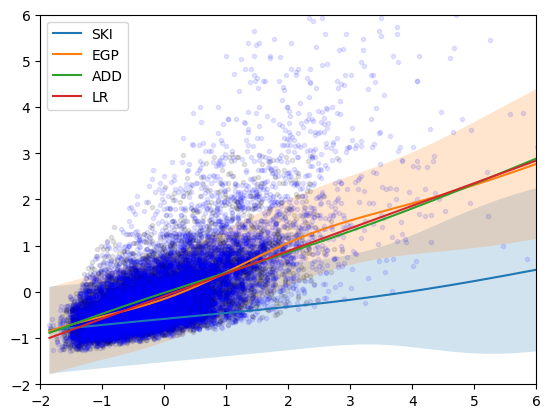

In [13]:
plt.plot(train_x, train_y, 'k.', alpha=0.1)
plt.plot(test_x, test_y, 'b.', alpha=0.1)

plt.xlim([-2, 6])
plt.ylim([-2, 6])

plt.plot(x_visual, SKI_visual_mean, label='SKI')
plt.fill_between(np.array(x_visual.reshape([1,-1]))[0], 
                 np.array(SKI_visual_mean.reshape([1,-1]))[0] + 1.96*np.sqrt(np.array(SKI_visual_var.reshape([1,-1]))[0]),
                 np.array(SKI_visual_mean.reshape([1,-1]))[0] - 1.96*np.sqrt(np.array(SKI_visual_var.reshape([1,-1]))[0]),
                alpha=0.2)

plt.plot(x_visual, EGP_visual_mean, label='EGP')
plt.fill_between(np.array(x_visual.reshape([1,-1]))[0], 
                 np.array(EGP_visual_mean.reshape([1,-1]))[0] + 1.96*np.sqrt(np.array(EGP_visual_var.reshape([1,-1]))[0]),
                 np.array(EGP_visual_mean.reshape([1,-1]))[0] - 1.96*np.sqrt(np.array(EGP_visual_var.reshape([1,-1]))[0]),
                alpha=0.2)

plt.plot(x_visual, ADD_visual_mean, label='ADD')

plt.plot(x_visual, LR_visual_mean, label='LR')
plt.legend()

#plt.fill_between(x_visual, SKI_visual_mean + 1.96*np.sqrt(SKI_visual_var), SKI_visual_mean - 1.96*np.sqrt(SKI_visual_var))
#plt.plot(x_visual, SKI_visual_mean + 1.96*np.sqrt(SKI_visual_var))
#plt.plot(x_visual, SKI_visual_mean - 1.96*np.sqrt(SKI_visual_var))

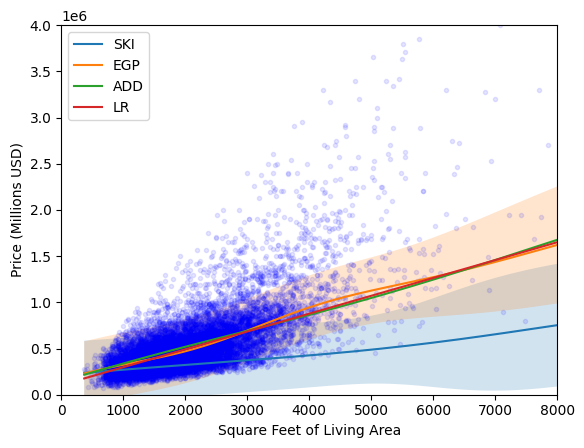

In [28]:
x_visual_unscaled = sqft_living_scaler.inverse_transform(np.array(x_visual).reshape([-1,1]))
sigma_unscaled = np.std(price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])))

plt.xlim([0, 8000])
plt.ylim([0, 4000000])

plt.plot(sqft_living_scaler.inverse_transform(np.array(test_x).reshape([-1,1])),
         price_scaler.inverse_transform(np.array(test_y).reshape([-1,1])), 'b.', alpha=0.1)

plt.plot(x_visual_unscaled, 
         price_scaler.inverse_transform(np.array(SKI_visual_mean).reshape([-1,1])), 
         label='SKI')
plt.fill_between(np.array(x_visual_unscaled.reshape([1,-1]))[0], 
                 np.array(price_scaler.inverse_transform(np.array(SKI_visual_mean).reshape([-1,1])).reshape([1,-1]))[0] + 1.96*sigma_unscaled*np.sqrt(np.array(SKI_visual_var.reshape([1,-1]))[0]),
                 np.array(price_scaler.inverse_transform(np.array(SKI_visual_mean).reshape([-1,1])).reshape([1,-1]))[0] - 1.96*sigma_unscaled*np.sqrt(np.array(SKI_visual_var.reshape([1,-1]))[0]),
                alpha=0.2)

plt.plot(x_visual_unscaled, 
         price_scaler.inverse_transform(np.array(EGP_visual_mean).reshape([-1,1])), 
         label='EGP')
plt.fill_between(np.array(x_visual_unscaled.reshape([1,-1]))[0], 
                 np.array(price_scaler.inverse_transform(np.array(EGP_visual_mean).reshape([-1,1])).reshape([1,-1]))[0] + 1.96*sigma_unscaled*np.sqrt(np.array(EGP_visual_var.reshape([1,-1]))[0]),
                 np.array(price_scaler.inverse_transform(np.array(EGP_visual_mean).reshape([-1,1])).reshape([1,-1]))[0] - 1.96*sigma_unscaled*np.sqrt(np.array(EGP_visual_var.reshape([1,-1]))[0]),
                alpha=0.2)

plt.plot(x_visual_unscaled, price_scaler.inverse_transform(np.array(ADD_visual_mean).reshape([-1,1])), label='ADD')

plt.plot(x_visual_unscaled, price_scaler.inverse_transform(np.array(LR_visual_mean).reshape([-1,1])), label='LR')

plt.xlabel('Square Feet of Living Area')
plt.ylabel('Price (Millions USD)')

plt.legend()